In [1]:
from google.colab import files
import cv2
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from typing import List
from matplotlib import pyplot as plt
import imageio

-----------------------------------------------------

In [2]:
vocab = [x for x in "abcçdefgğhıijklmnoöpqrsştuüvwxyz'?!0123456789 "] # Turkish and English alphabets

In [3]:
char_to_num = {char: idx for idx, char in enumerate(vocab)}
num_to_char = {idx: char for char, idx in char_to_num.items()}


In [4]:
print(f"Vocabulary (char_to_num): {char_to_num}")
print(f"Inverse Vocabulary (num_to_char): {num_to_char}")
print(f"Vocabulary Size (size): {len(vocab)}")
word = "hello" # Example

index = [char_to_num.get(char) for char in word]
print(f"'{word}' = {index}")

returned_word = "".join([num_to_char[idx] for idx in index])
print(f"Reconstruction = '{returned_word}'")

Vocabulary (char_to_num): {'a': 0, 'b': 1, 'c': 2, 'ç': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'ğ': 8, 'h': 9, 'ı': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'ö': 18, 'p': 19, 'q': 20, 'r': 21, 's': 22, 'ş': 23, 't': 24, 'u': 25, 'ü': 26, 'v': 27, 'w': 28, 'x': 29, 'y': 30, 'z': 31, "'": 32, '?': 33, '!': 34, '0': 35, '1': 36, '2': 37, '3': 38, '4': 39, '5': 40, '6': 41, '7': 42, '8': 43, '9': 44, ' ': 45}
Inverse Vocabulary (num_to_char): {0: 'a', 1: 'b', 2: 'c', 3: 'ç', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'ğ', 9: 'h', 10: 'ı', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'ö', 19: 'p', 20: 'q', 21: 'r', 22: 's', 23: 'ş', 24: 't', 25: 'u', 26: 'ü', 27: 'v', 28: 'w', 29: 'x', 30: 'y', 31: 'z', 32: "'", 33: '?', 34: '!', 35: '0', 36: '1', 37: '2', 38: '3', 39: '4', 40: '5', 41: '6', 42: '7', 43: '8', 44: '9', 45: ' '}
Vocabulary Size (size): 46
'hello' = [9, 5, 14, 14, 17]
Reconstruction = 'hello'


In [5]:
class LipReadingDataset(Dataset):
  def __init__(self, data_paths: list[str], char_to_num: dict):
    self.data_paths = data_paths
    self.char_to_num = char_to_num

  def __len__(self):
    return len(self.data_paths)

  def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
    video_path = self.data_paths[idx]
    file_name = os.path.basename(video_path).split('.')[0]
    alignment_path = os.path.join('data',f'{file_name}.align')

    frames = self._load_video(video_path)
    alignments = self._load_alignments(alignment_path)
    tokens = [self.char_to_num[char] for char in alignments if char in self.char_to_num]

    return frames, torch.tensor(tokens, dtype=torch.int)


  # Frames
  def _load_video(self, path: str) -> torch.Tensor:
    cap = cv2.VideoCapture(path)
    frames_raw = []

    pix_sum = 0.0
    pix_sq_sum = 0.0
    num_pix = 0

    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      mouth_roi = frame[190:236, 80:220] # Mouth area
      frames_raw.append(mouth_roi)

      frame_normalized = frame / 255.0
      pix_sum += np.sum(frame_normalized)
      pix_sq_sum += np.sum(frame_normalized ** 2)
      num_pix += frame_normalized.size

    cap.release()

    if num_pix == 0:
        return torch.empty(0) # Return empty tensor if no frames

    mean = pix_sum / num_pix
    std = np.sqrt(pix_sq_sum / num_pix - mean**2)

    frames_normalized_list = []
    for frame in frames_raw:
      frame_normalized = (frame / 255.0 - mean) / std
      frames_normalized_list.append(frame_normalized)

    v_tensor = torch.tensor(np.array(frames_normalized_list), dtype=torch.float32)
    return v_tensor.unsqueeze(0)

  # Transcription files
  def _load_alignments(self, align_path: str) -> torch.Tensor:
    ext = os.path.splitext(align_path)[1]
    clean_text=""

    if ext == '.align': # Similar to Grid Corpus
      words = []
      with open(align_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip().split()
            if len(line) >= 3:
              if line[-1] != 'sil':
                  words.append(line[-1])
      clean_text = " ".join(words)

    else: # .txt etc.
      with open(align_path, 'r', encoding='utf-8') as f:
        text = f.read()
        clean_text = text.strip()

    return clean_text.lower()

In [6]:
data_dir = '/content/data'
video_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.mpg')]
alignment_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.align')]

print(f"Found video files: {video_files} and {alignment_files}")


Found video files: ['/content/data/bbaf2n.mpg'] and ['/content/data/bbaf2n.align']


In [7]:
lip_reading_dataset = LipReadingDataset(video_files, char_to_num)

In [8]:
video_data, text_labels = lip_reading_dataset[0]

print(f"Dataset Sample - Video: {video_data.shape}, Labels: {text_labels}")

Dataset Sample - Video: torch.Size([1, 75, 46, 140]), Labels: tensor([ 1, 11, 16, 45,  1, 14, 25,  5, 45,  0, 24, 45,  6, 45, 24, 28, 17, 45,
        16, 17, 28], dtype=torch.int32)


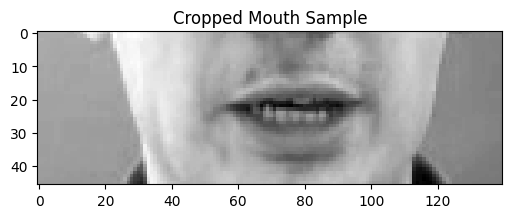

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.title("Cropped Mouth Sample")
plt.imshow(video_data[0, 50].numpy(), cmap='gray')
plt.axis('on')
plt.show()

In [10]:
original_text = lip_reading_dataset._load_alignments(alignment_files[0])
reconstructed = "".join([num_to_char[token.item()] for token in text_labels])

print(f"Original Text from File:  {original_text}")
print(f"Reconstructed from Tokens: {reconstructed}")

Original Text from File:  bin blue at f two now
Reconstructed from Tokens: bin blue at f two now
